# Annotation Validator
## Provides a visual validation of the Annotations on a specific image

In [1]:
"""
23/03/21 09:44
Developed by Miles Danswan
"""

'\n23/03/21 09:44\nDeveloped by Miles Danswan\n'

In [2]:
import os  # traversing the native filesystem
import numpy as np  # specific array operations
import json as js  # parsing the json annotation files
import tkinter.filedialog as fd  # open file dialog (retrieiving json files)
import matplotlib.pyplot as plt  # working with skimage
# creating tkinter canvas from MPL figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from skimage import io  # processing images
from tkinter import *  # displaying a native window
from tkinter import ttk  # extended ttk widget support
import enum  # encapsulating constants

In [3]:
class REGION_TYPES(enum.Enum):
    circular = 0
    rect = 1
    polygon = 2

## Class Definitions

In [4]:
class Region:

    REGION_TYPE_FILL_COLOURS = {REGION_TYPES.circular: "steelblue",
                                REGION_TYPES.rect: "orangered",
                                REGION_TYPES.polygon: "red"}
    REGION_BORDER_WIDTH = 2
    REGION_ALPHA = 0.4

    REGION_LABEL_FONT_SIZE = 10
    REGION_LABEL_DISP = 5
    REGION_LABEL_WEIGHT = "bold"
    REGION_LABEL_FG = "white"
    REGION_LABEL_BBOX = dict(
        facecolor="black", edgecolor="blue", alpha=0.5, linewidth=2)

    def __init__(this, region_type, class_name, notes):
        this.region_type = region_type
        this.class_name = class_name
        this.notes = notes


class PolygonRegion(Region):

    def __init__(this, region_type, class_name, notes, x_points, y_points):
        Region.__init__(this, region_type, class_name, notes)
        this.region_type = region_type
        this.class_name = class_name
        this.notes = notes
        this.x_points = x_points
        this.y_points = y_points

    def calc_bbox(this):

        x_left = np.min(this.x_points)
        x_right = np.max(this.x_points)
        y_top = np.min(this.y_points)
        y_bottom = np.max(this.y_points)

        this.bbox = (x_left, x_right, y_top, y_bottom)

        return this.bbox
    
    def get_regions(this, window_height):
        
        region_points = []
                
        for idx in range(len(this.x_points)):
            region_points.append((this.x_points[idx], window_height - this.y_points[idx]))
            
        return region_points
            

class RectRegion(Region):

    def __init__(this, region_type, class_name, notes, x, y, width, height):
        Region.__init__(this, region_type, class_name, notes)
        this.region_type = region_type
        this.class_name = class_name
        this.notes = notes
        this.x = x
        this.y = y
        this.width = width
        this.height = height

    def calc_bbox(this):

        x_left = this.x
        x_right = this.x + this.width
        y_top = this.y
        y_bottom = this.y + this.height

        this.bbox = (x_left, x_right, y_top, y_bottom)

        return this.bbox


class AnnotatedImage(list):

    def __init__(this, imagepath, regions):
        list.__init__(this, regions)
        this.imagepath = imagepath
        this.filename = os.path.basename(imagepath)
        this.directory = os.path.split(imagepath)[0]
        this.annotationpath = None
        this.data = None
        this.image_width = 800
        this.image_height = 600

    def load_image(this):
        try:
            this.data = io.imread(this.imagepath)
            this.image_width = this.data.shape[1]
            this.image_height = this.data.shape[0]
        except:
            raise Exception("Unable to read image data at '%s'" %
                            (this.imagepath))

    def resolve_annotation_file(this):

        filename = os.path.splitext(this.filename)[0]

        # Attempt to find the corresponding image file (recognised img files: png, jpg, jpeg)
        for fn in os.listdir(this.directory):
            if ((filename in fn) and (fn.endswith(".json"))):
                this.annotationpath = os.path.join(this.directory, fn)
                return

        raise Exception(
            "Unable to resolve Annotation File for image '%s'" % (this.imagepath))

    def load_annotation_file(this):

        if (this.annotationpath == None):
            raise Exception(
                "Annotation Path is Empty for image '%s'" % (this.imagepath))
            return

        try:
            with open(this.annotationpath) as json:
                data = js.load(json)
                image_id = data["_via_image_id_list"][0]
                anno_data = data["_via_img_metadata"][image_id]
                for region in anno_data["regions"]:
                    reg_shape_attr = region["shape_attributes"]
                    reg_attr = region["region_attributes"]
                    if (reg_shape_attr["name"] == REGION_TYPES.polygon.name):
                        x_region_points = []
                        y_region_points = []
                        for i in range(len(reg_shape_attr["all_points_x"])):
                            x_region_points.append(
                                reg_shape_attr["all_points_x"][i])
                            y_region_points.append(
                                reg_shape_attr["all_points_y"][i])
                        new_region = PolygonRegion(
                            REGION_TYPES.polygon, reg_attr["Class"], reg_attr["Notes"], x_region_points, y_region_points)
                        this.append(new_region)
                    elif (reg_shape_attr["name"] == REGION_TYPES.rect.name):
                        new_region = RectRegion(REGION_TYPES.rect, reg_attr["Class"], reg_attr["Notes"], reg_shape_attr[
                            "x"], reg_shape_attr["y"], reg_shape_attr["width"], reg_shape_attr["height"])
                        this.append(new_region)
        except Exception as e:
            print("Unable to open Annotation File at '%s'" %
                  (this.annotationpath))
            print(e)

    def get_num_of_regions_by_type(this, region_type):
        c = 0
        for region in this:
            if region.region_type == region_type:
                c += 1
        return c

    def get_num_of_regions(this):
        return len(this)

    def __repr__(this):
#         os.path.splitext(this.filename)
        return this.filename

class AnnotatedImages(list):

    def __init__(this, annotated_images):
        list.__init__(this, annotated_images)
        this.annotated_images = annotated_images

    def get_annotated_image_names(this):
        
        filenames = []
        
        for annotated_image in this:
            filenames.append(annotated_image.__repr__())
            
        return filenames
    
    def resolve_annotated_image(this, image_name):
        
        annotated_image = None
        
        for image in this:
            if (image_name in image.filename):
                annotated_image = image
                break
            
        return annotated_image
        
    def get_num_of_images(this):
        return len(this)
    
    def __repr__(this):
        return str(this.get_num_of_images())

In [5]:
"""
CONSTANTS
"""
WINDOW_BG = "black"

SIDEPANEL_BG = "white"

In [6]:
"""
Creates an OpenFileName dialog for Retrieving a Filename
"""


def get_filename(root):
    return fd.askopenfilename(parent=root, filetypes=[("Annotation Files", "*.json"), ("All", "*.*")])

In [7]:
"""
Creates an OpenDirectory dialog for Retrieving a Directory Name
"""


def get_dirname(root):
    return fd.askdirectory(parent=root)

In [8]:
"""
Retrieves a list of image names from the top level directory of the provided path
"""


def get_dir_img_list(root):

    dirpath = get_dirname(root)
    annotated_img_list = AnnotatedImages([])

    for (dirpath, subdirs, filenames) in os.walk(dirpath):
        for fn in filenames:
            if (fn.endswith(".png") or fn.endswith(".jpg") or fn.endswith(".jpeg")):
                new_annotated_image = AnnotatedImage(os.path.join(dirpath, fn), [])
                annotated_img_list.append(new_annotated_image)

    return annotated_img_list

In [9]:
"""
Determines the significant (highest y-value and Lowest x-value) point in the provided inverted poly region
"""


def get_poly_sig_point(v_inverted_region):

    sig_point_x = v_inverted_region[0][0]
    sig_point_y = v_inverted_region[0][1]

    for point in v_inverted_region:
        if (point[0] < sig_point_x):
            sig_point_x = point[0]
        if (point[1] > sig_point_y):
            sig_point_y = point[1]

    return (sig_point_x, sig_point_y)

In [10]:
"""
Defines a visual widget for each individual 'poly' and 'rect' region point
"""


def create_annotations(axis, window_width, window_height, annotated_image):

    for region in annotated_image:
        if region.region_type == REGION_TYPES.polygon:
            bbox = region.calc_bbox()
            region_points = region.get_regions(window_height)
            axis.text(bbox[0],
                      window_height - bbox[2] + Region.REGION_LABEL_DISP,
                      region.class_name,
                      fontsize=Region.REGION_LABEL_FONT_SIZE,
                      fontweight=Region.REGION_LABEL_WEIGHT,
                      bbox=Region.REGION_LABEL_BBOX,
                      color=Region.REGION_LABEL_FG)
            axis.add_patch(plt.Polygon(region_points,
                                       edgecolor=Region.REGION_TYPE_FILL_COLOURS[REGION_TYPES.polygon],
                                       linewidth=Region.REGION_BORDER_WIDTH,
                                       alpha=Region.REGION_ALPHA))
        elif region.region_type == REGION_TYPES.rect:
            bbox = region.calc_bbox()
            axis.text(bbox[0], window_height - bbox[2] + Region.REGION_LABEL_DISP,
                  region.class_name,
                  fontsize=Region.REGION_LABEL_FONT_SIZE,
                  fontweight=Region.REGION_LABEL_WEIGHT,
                  bbox=Region.REGION_LABEL_BBOX,
                  color=Region.REGION_LABEL_FG)
            axis.add_patch(plt.Rectangle((bbox[0], window_height - bbox[2] - region.height),
                                     region.width,
                                     region.height,
                                     edgecolor=Region.REGION_TYPE_FILL_COLOURS[REGION_TYPES.rect],
                                     linewidth=Region.REGION_BORDER_WIDTH,
                                     alpha=Region.REGION_ALPHA))

In [11]:
"""
Creates a basic TK Window with the provided name and width x height
"""


def create_window(name, w_x_h):

    main = Tk()
    main.title(name)
    main.geometry(w_x_h)
    main["bg"] = WINDOW_BG

    return main

In [12]:
zoom_in_factor = 0.05
zoom_out_factor = 0.05
zoomed = False

move_start_xlim = None
move_start_ylim = None
move_start_point = None
move_end_point = None


def move_figure_start(event):
    global move_start_point, axis, move_start_xlim, move_start_ylim

    move_start_point = (event.x_root, event.y_root)
    move_start_xlim = axis.get_xlim()
    move_start_ylim = axis.get_ylim()


def move_figure_stop(event):
    global fig_canvas

    fig_canvas._tkcanvas.config(cursor="tcross")


def move_figure(event):
    global main, fig_canvas, axis, move_start_point, move_end_point, move_start_xlim, move_start_ylim

    fig_canvas._tkcanvas.config(cursor="sizing")

    move_end_point = (event.x_root, event.y_root)

    cur_xlim = axis.get_xlim()
    cur_ylim = axis.get_ylim()
    new_xlim = [move_start_xlim[0] + (move_end_point[0] - move_start_point[0]),
                move_start_xlim[1] + (move_end_point[0] - move_start_point[0])]
    new_ylim = [move_start_ylim[0] + ((move_end_point[1] - move_start_point[1]) * -1),
                move_start_ylim[1] + ((move_end_point[1] - move_start_point[1]) * -1)]
    axis.set_xlim(new_xlim)
    axis.set_ylim(new_ylim)

    fig_canvas.draw()


def zoom_figure(event):
    global main, fig_canvas, zoom_in_factor, zoom_out_factor, zoomed, axis

    cur_xlim = axis.get_xlim()
    cur_ylim = axis.get_ylim()

    if (event.delta > 0):
        new_xlim_l, new_xlim_r = (cur_xlim[0] + (main.winfo_width() / 2) * zoom_in_factor,
                                  cur_xlim[1] - (main.winfo_width() / 2) * zoom_in_factor)
        new_ylim_t, new_ylim_b = (cur_ylim[0] + (main.winfo_height() / 2) * zoom_in_factor,
                                  cur_ylim[1] - (main.winfo_height() / 2) * zoom_in_factor)
        # if zoomed into the opposite view, prevent further zoom
        if (new_xlim_r < new_xlim_l or new_ylim_t > new_ylim_b):
            return
        axis.set_xlim([new_xlim_l, new_xlim_r])
        axis.set_ylim([new_ylim_t, new_ylim_b])
        fig_canvas.draw()
        zoomed = True
    elif (event.delta < 0 and zoomed):
        new_xlim_l, new_xlim_r = (cur_xlim[0] - (main.winfo_width() / 2) * zoom_in_factor,
                                  cur_xlim[1] + (main.winfo_width() / 2) * zoom_in_factor)
        new_ylim_t, new_ylim_b = (cur_ylim[0] - (main.winfo_height() / 2) * zoom_in_factor,
                                  cur_ylim[1] + (main.winfo_height() / 2) * zoom_in_factor)
        # if zoomed outside of the primary view, prevent further reducing zoom
        if (new_xlim_l < 0 or new_xlim_r > data.shape[1] or new_ylim_t < 0 or new_ylim_b > data.shape[0]):
            axis.set_xlim([0, data.shape[1]])
            axis.set_ylim([0, data.shape[0]])
            fig_canvas.draw()
            zoomed = False
            return
        axis.set_xlim([new_xlim_l, new_xlim_r])
        axis.set_ylim([new_ylim_t, new_ylim_b])
        fig_canvas.draw()

In [13]:
def image_changed(event):
    global annoImageFilenamesCb, annotated_images

    annotated_image = annotated_images.resolve_annotated_image(annoImageFilenamesCb.get())

    update_canvas(annotated_image)

In [14]:
def update_canvas(annotated_image):
    global axis, fig_canvas, main, f

    if axis != None:
        fig_canvas._tkcanvas.pack_forget()
        axis.remove()
        axis = None
        
    if annotated_image == None:
        return
    else:
        annotated_image.load_image()
        annotated_image.resolve_annotation_file()
        annotated_image.load_annotation_file()
        
    # Update window width and height
    main.geometry(str(annotated_image.image_width) +
                  "x" + str(annotated_image.image_height))

    axis = f.add_subplot(111)
    create_annotations(
        axis, annotated_image.image_width, annotated_image.image_height, annotated_image)
    axis.set_xlim([0, annotated_image.image_width])
    axis.set_ylim([0, annotated_image.image_height])
    f.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.axis("off")
    img = plt.imshow(np.flipud(annotated_image.data))

    # Creating a canvas for the Figure
    fig_canvas = FigureCanvasTkAgg(f, master=main)
    fig_canvas._tkcanvas.pack(expand=1, fill="both")
    fig_canvas._tkcanvas.config(cursor="tcross")

    # Bind the canvas zoom and move commands ButtonRelease-1
    fig_canvas._tkcanvas.bind("<ButtonPress-1>", move_figure_start)
    fig_canvas._tkcanvas.bind("<ButtonRelease-1>", move_figure_stop)
    fig_canvas._tkcanvas.bind("<B1-Motion>", move_figure)
    fig_canvas._tkcanvas.bind("<MouseWheel>", zoom_figure)

In [15]:
sidebar = None
openFileBtn = None
selectedImage = None
annoImageFilenamesCb = None


def create_sidebar(root, annotated_images):
    global sidebar, openFileBtn, selectedImage, annoImageFilenamesCb

    # create and pack sidebar frame
    sidebar = Frame(root, bg=SIDEPANEL_BG)
    sidebar.pack(side="right", fill="both")

    # create and pack open file button
    openFileBtn = ttk.Button(sidebar, text="Open Folder")
    openFileBtn.pack()

    # Create combobox for displaying image names in a selected folder
    selectedImage = StringVar()
    annoImageFilenamesCb = ttk.Combobox(sidebar, textvariable=selectedImage)
    annoImageFilenamesCb["values"] = annotated_images.get_annotated_image_names()
    annoImageFilenamesCb.current(0)
    annoImageFilenamesCb.pack()
    annoImageFilenamesCb.bind('<<ComboboxSelected>>', image_changed)

    return

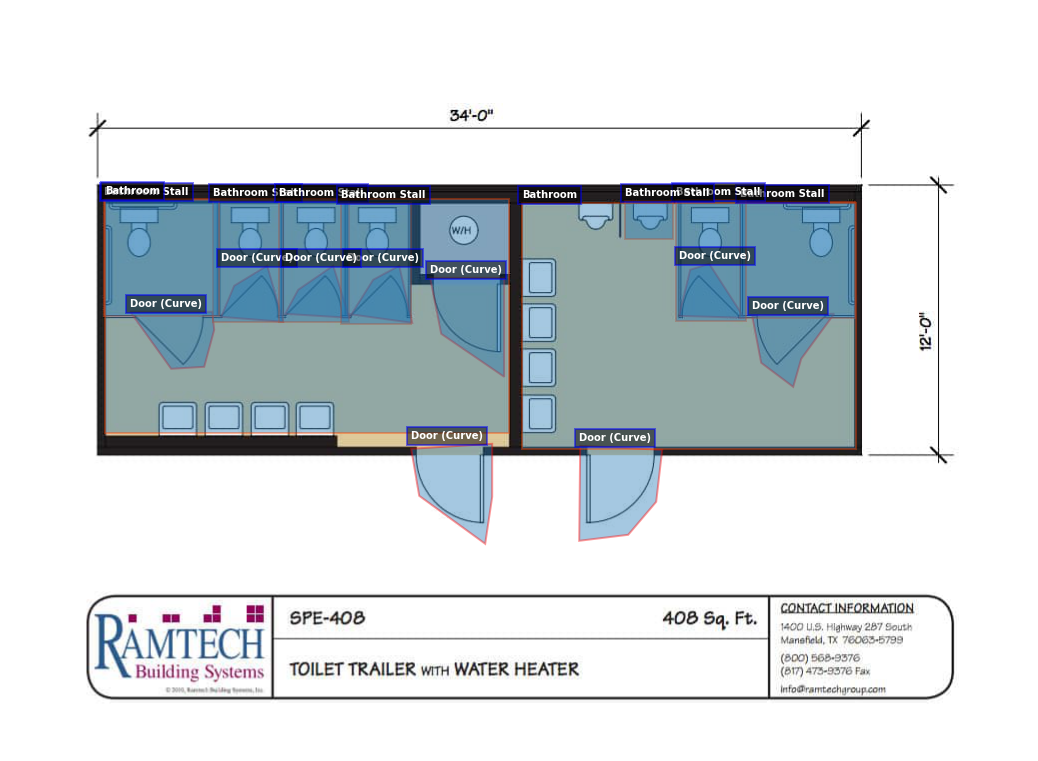

In [16]:
axis = None
main = None

f = plt.figure(figsize=(1, 1))

# Creating a Tkinter Window to host the Annotated Image and Annotations
main = create_window("Annotation Validator", "800x600")

annotated_images = get_dir_img_list(main)

# Creating the sidebar which host options and functions for using the annotation validation tool
current_img_dir = create_sidebar(main, annotated_images)

update_canvas(annotated_images.resolve_annotated_image(annoImageFilenamesCb.get()))

main.mainloop()